In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [8]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']


In [4]:
def get_metrics(y_test, y_pred):
    print("confusion_matrix:")
    # print(confusion_matrix(y_test, y_pred))

    # Plot confusion matrix, showing the values in each cell
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    # Show the values
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            plt.text(x, y, str(cm[x,y]), va='center', ha='center')

    # Set axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100}%")
    

In [5]:
def find_threshold(y_pred, y_true):
    p, r, thresholds = precision_recall_curve(y_true, y_pred)

    f1 = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1])

    # Plot the model precision-recall curve

    df = pd.DataFrame({'Precision': p[:-1], 'Recall': r[:-1], 'Threshold': thresholds})

    # df.set_index('Threshold', inplace=True)

    # df["Accuracy"] = df.apply(lambda row: accuracy_score(y_true, y_pred >= row.name), axis=1)

    # USe f1 to find thresh
    threshold = df.iloc[f1.argmax()]['Threshold']

    df.plot(x="Threshold", y=["Precision", "Recall"], figsize=(10, 5), grid=True)
    # Add a vertical line at the threshold that maximizes F1 score
    plt.vlines(threshold, 0, 1, linestyle='--')

    return threshold


In [51]:
train_data = pd.read_csv('../census-income.data',header=None)

test_data = pd.read_csv('../census-income.test',header=None)

# Add a column for 'test'
test_data['test'] = 1
train_data['test'] = 0

# Concatenate the dataframes

data = pd.concat([train_data, test_data])

data.dropna(inplace=True)

data.columns=column_names + ['test']

data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)

# Use get dummies to convert categorical variables to binary

data = pd.get_dummies(data, columns=categorical_predictors)

# Update the predictors list
all_cols = set(data.columns)

non_predictors = set(column_names) - set(predictors)

predictors = list(all_cols - non_predictors - set(['test', 'income', '>50K'])) 

# Split the data back into train and test
train_data = data.loc[data['test'] == 0]
test_data = data.loc[data['test'] == 1]

# Drop the test column
train_data = train_data.drop('test', axis=1)
test_data = test_data.drop('test', axis=1)

# Split the data into X and y
X_train = train_data[predictors]
y_train = train_data['>50K']

X_test = test_data[predictors]
y_test = test_data['>50K']

In [52]:
y_test.value_counts()

0    93576
1     6186
Name: >50K, dtype: int64

In [73]:
# Train an ADABoost model
ada = AdaBoostClassifier(n_estimators=250, random_state=0)

ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=250, random_state=0)

0.49923120198558524

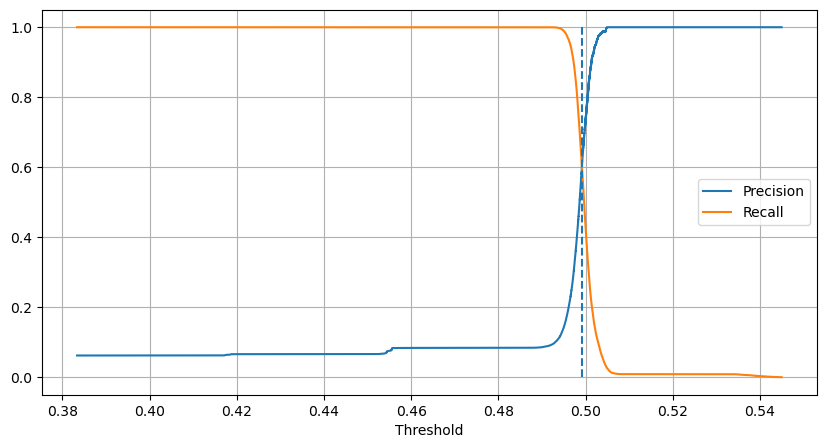

In [74]:
y_pred_probs_train = ada.predict_proba(X_train)[:, 1]

threshold = find_threshold(y_pred_probs_train, y_train)
threshold

In [82]:
y_pred_probs = ada.predict_proba(X_test)[:, 1]


confusion_matrix:
Accuracy: 91.16998456326057%
Recall: 81.74911089557064%
Precision: 39.703226819502234%


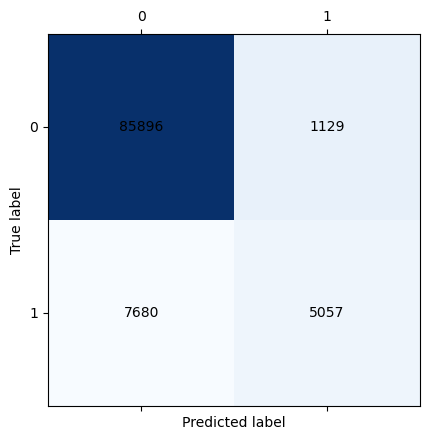

In [79]:
# Find the resulting predictions
thresh = 0.498
y_pred = y_pred_probs >= thresh
y_pred = y_pred.astype(int)

get_metrics(y_test, y_pred)

In [86]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': ada.feature_importances_, 'error': ada.feature_names_in_})
importance_df.sort_values('Importance', ascending=False, inplace=True)
importance_df.set_index('Feature', inplace=True)
importance_df.head(20)

,Importance,error
Feature,,
cap_gain,0.136,cap_gain
cap_loss,0.108,cap_loss
dividend,0.052,dividend
age,0.052,age
weeks_worked,0.048,weeks_worked
inst_weight,0.028,inst_weight
wage_hr,0.024,wage_hr
education_ Prof school degree (MD DDS DVM LLB JD),0.008,education_ Prof school degree (MD DDS DVM LLB JD)
education_ Masters degree(MA MS MEng MEd MSW MBA),0.008,education_ Masters degree(MA MS MEng MEd MSW MBA)


In [62]:
threshold

0.49761774875574016

In [80]:
train_data['inst_weight'].describe()

count    199523.000000
mean       1740.380269
std         993.768156
min          37.870000
25%        1061.615000
50%        1618.310000
75%        2188.610000
max       18656.300000
Name: inst_weight, dtype: float64

array([0.05591837, 0.23773382, 0.35334404, 0.36179085, 0.36450586,
       0.42372606, 0.44275619, 0.46327017, 0.47118521, 0.4682595 ,
       0.41646509, 0.44468941, 0.47500371, 0.47301074, 0.4838415 ,
       0.45200944, 0.47687059, 0.48621889, 0.45161088, 0.45595167,
       0.47200075, 0.4833579 , 0.48174572, 0.49453445, 0.48931163,
       0.4704276 , 0.48822468, 0.47317636, 0.48955443, 0.49135916,
       0.49043393, 0.49244289, 0.49422255, 0.48494942, 0.48866685,
       0.47240093, 0.49288463, 0.49010723, 0.47341087, 0.4786852 ,
       0.49272254, 0.48609848, 0.48952219, 0.49231382, 0.49476048,
       0.49523654, 0.49629526, 0.49110108, 0.49375861, 0.49032827,
       0.47824409, 0.48901645, 0.48789998, 0.49227849, 0.49832456,
       0.48867135, 0.49605219, 0.49216963, 0.48576137, 0.48966164,
       0.49474793, 0.49595124, 0.49772925, 0.49401645, 0.4946295 ,
       0.492372  , 0.49558306, 0.4837238 , 0.49699713, 0.49847229,
       0.49541806, 0.49312352, 0.49464058, 0.49586643, 0.49626